In [27]:
import torchvision
import torchvision.transforms as transforms
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and Load the MNIST dataset
transform = transforms.ToTensor()
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the trainset into training and validation datasets
train_size = int(0.8 * len(full_trainset))  # 80% for training
val_size = len(full_trainset) - train_size  # remaining 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [28]:
import matplotlib.pyplot as plt

def display_images(images, n, images_per_row=5, labels = None):
    """
    Display n images in rows where each row contains a specified number of images.

    Parameters:
    - images: List/Tensor of images to display.
    - n: Number of images to display.
    - images_per_row: Number of images per row.
    """
    # Define the number of rows based on n and images_per_row
    num_rows = (n + images_per_row - 1) // images_per_row  # Rounding up
    plt.figure(figsize=(2*images_per_row, 1.25 * num_rows))
    for i in range(n):
        plt.subplot(num_rows, images_per_row, i+1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        if labels is not None:
          plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


for batch in trainloader:
  # In a batch from many batches in trainloader, get the the first one and work with that
  batch_size = len(batch[0])
  display_images(images= batch[0],n = batch_size, images_per_row=8, labels = batch[1].tolist())
  break


KeyboardInterrupt: 

In [ ]:
# SANITY CHECK
in_channels_arg = 1
out_channels_arg = 1
batch_size = 32
height = 28
width = 28
total_timesteps = 1000
start_beta, end_beta = 1e-4, 0.02


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sanity check
x = torch.randn((batch_size, in_channels_arg, height, width)).to(device)
diffuser = NoiseDiffuser(start_beta, end_beta, total_timesteps, device)



timesteps_to_display = torch.randint(0, total_timesteps, (batch_size,), device=device).long().tolist()
print(timesteps_to_display)
y = diffuser.noise_diffusion(x, timesteps_to_display)

assert len(x.shape) == len(y.shape)
assert y.shape == x.shape

print("Sanity Check for shape mismatches")
print("Shape of the input : ", x.shape)
print("Shape of the output : ", y.shape)

[410, 280, 809, 97, 574, 959, 390, 436, 181, 160, 431, 72, 130, 888, 909, 417, 85, 208, 22, 177, 58, 600, 142, 196, 492, 678, 309, 395, 567, 456, 935, 726]


AttributeError: 'tuple' object has no attribute 'shape'

TypeError: Invalid shape (32, 28, 28) for image data

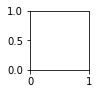

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_timesteps = 1000
start_beta, end_beta = 1e-4, 0.02
diffuser = NoiseDiffuser(start_beta, end_beta, total_timesteps, device)

for batch in trainloader:
    minibatch = batch[0]
    batch_size = len(minibatch)
    timesteps_to_display = torch.randint(0, total_timesteps, (batch_size,), device=device).long().tolist()
    noisy_images = diffuser.noise_diffusion(minibatch, timesteps_to_display)
    display_images(images=noisy_images, n=batch_size, images_per_row=8, labels=list(map(lambda x: "time-step: " + str(x), timesteps_to_display)))
    break



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class NoiseDiffuser:
    def __init__(self, start_beta, end_beta, total_steps, device):

        assert start_beta < end_beta < 1.0

        self.device = device
        self.start_beta = start_beta
        self.end_beta = end_beta
        self.total_steps = total_steps

        self.betas = torch.linspace(self.start_beta, self.end_beta, steps = self.total_steps, device = device)

        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim = 0)
    
    def noise_diffusion(self, image, t):
        image = image.to(self.device)
        random_noise = torch.randn(image.shape, device = self.device)

        sqrt_alphabar = torch.sqrt(self.alpha_bar)

        processed_image = sqrt_alphabar[t].view(image.shape[0], 1, 1, 1) * image + (1 - self.alpha_bar[t].view(image.shape[0], 1, 1, 1)) * random_noise

        return processed_image, image

class UNet(nn.Module):

    def __init__(self, in_channels, out_channels):
      
      super(UNet, self).__init__()

      self.ini = self.doubleConvolution(inC = in_channels, oC = 16)
      self.down1 = self.Down(inputC = 16, outputC = 32)
      self.down2 = self.Down(inputC = 32, outputC = 64)

      self.time_emb2 = self.timeEmbeddings(1, 64)
      self.up2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2) #144,912
      self.afterup2 = self.doubleConvolution(inC = 64 , oC = 32)

      self.time_emb1 = self.timeEmbeddings(1, 32)
      self.up1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
      self.afterup1 = self.doubleConvolution(inC = 32 , oC = 16, kS1=5, kS2=4)

      self.out = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x, t=None):
      assert t is not None
      x = x.to(device)
      t = t.to(device)
      
      x1 = self.ini(x)                  # Initial Double Convolution
      x2 = self.down1(x1)               # Downsampling followed by Double Convolution
      x3 = self.down2(x2)               # Downsampling followed by Double Convolution
      
      t2 = self.time_emb2(t)[:,:, None, None]
      y2 = self.up2(x3 + t2)                                                                    # Upsampling
      y2 = self.afterup2(torch.cat([y2, self.xLikeY(x2, y2)], axis = 1))                       # Crop corresponding Downsampled Feature Map, Double Convolution

      t1 = self.time_emb1(t)[:,:, None, None]
      y1 = self.up1(y2 + t1)                                                                    # Upsampling
      y1 = self.afterup1(torch.cat([y1, self.xLikeY(x1, y1)], axis = 1))                       # Crop corresponding Downsampled Feature Map, Double Convolution
      outY = self.out(y1)               # Output Layer (ks-1, st-1, pa-0)

      return outY

    def timeEmbeddings(self, inC, oSize):
      """
      inC: Input Size, (for example 1 for timestep)
      oSize: Output Size, (Number of channels you would like to match while upsampling)
      """
      return nn.Sequential(nn.Linear(inC, oSize),
                            nn.ReLU(),
                            nn.Linear(oSize, oSize))

    def doubleConvolution(self, inC, oC, kS1=3, kS2=3, sT=1, pA=1):
      """
      Building Double Convolution as in original paper of Unet
      inC : inputChannels
      oC : outputChannels
      kS1 : Kernel_size of first convolution
      kS2 : Kernel_size of second convolution
      sT: stride
      pA: padding
      """
      return nn.Sequential(
            nn.Conv2d(in_channels= inC, out_channels=oC, kernel_size=kS1, stride=sT, padding=pA, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = oC,out_channels=oC, kernel_size=kS2, stride=sT, padding=pA, bias=False),
            nn.ReLU(inplace=True),
      )


    def Down(self, inputC, outputC, dsKernelSize = None):
      """
      Building Down Sampling Part of the Unet Architecture (Using MaxPool) followed by double convolution
      inputC : inputChannels
      outputC : outputChannels
      """

      return nn.Sequential(
          nn.MaxPool2d(2),
          self.doubleConvolution(inC = inputC, oC = outputC)
      )


    def xLikeY(self, source, target):
      """
      Helper function to resize the downsampled x's to concatenate with upsampled y's as in Unet Paper
      source: tensor whose shape will be considered ---------UPSAMPLED TENSOR (y)
      target: tensor whose shape will be modified to align with target ---------DOWNSAMPLED TENSOR (x)
      """
      x1 = source
      x2 = target
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
      return x1



In [39]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, diffuser, totalTrainingTimesteps):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        total_train_loss = 0

        # Wrapping your loader with tqdm to display progress bar
        train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for batch_idx, (data, _) in train_progress_bar:
            data = data.to(device)
            # Use a random time step for training
            batch_size = len(data)
            timesteps = torch.randint(0, totalTrainingTimesteps, (batch_size,), device=device).long().tolist()
        
            noisy_data, image = diffuser.noise_diffusion(data, torch.tensor(timesteps))
            plt.imshow(data.cpu()[0].numpy().reshape(28,28,1))
            plt.show()
            plt.imshow(noisy_data.cpu()[0].numpy().reshape(28,28,1))
            plt.show()
            predicted_noise = model(x=noisy_data, t = torch.tensor(timesteps).to(torch.float32).to(device).view(-1,1))
            plt.imshow(predicted_noise.cpu()[0].detach().numpy().reshape(28,28,1))
            plt.show()
            loss = criterion( data, predicted_noise)
            loss.backward()
            
                #print("grad accumulated, performing step and zero grad")
            
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
            train_progress_bar.set_postfix({'Train Loss': f'{loss.item():.4f}'})
        epoch_duration = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds')
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0

        # Wrapping your validation loader with tqdm to display progress bar
        val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch_idx, (data, _) in val_progress_bar:
                data = data.to(device)

                # For simplicity, we can use the same random timestep for validation
                batch_size = len(data)
                timesteps = torch.randint(0, totalTrainingTimesteps, (batch_size,), device=device).long().tolist()

                ############################################################################
                #                                 TO DO                                    #
                #                     Calculate Noisy data, True noise                     #
                #                 and Predicted Noise, & then feed it to criterion         #
                ############################################################################
                #raise NotImplementedError
                noisy_data, true_noise = diffuser.noise_diffusion(data, timesteps)
                predicted_noise = model.forward(x=noisy_data, t = torch.tensor(timesteps).to(torch.float32).to(device).view(-1,1))
                B,C,h,w = true_noise.shape
                loss = criterion(data, predicted_noise)
                total_val_loss += loss.item()
                val_progress_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses



In [ ]:
#Parameters

batch_size = 1024
total_timesteps = 1000
startBeta, endBeta = 1e-4, 0.02
inputChannels, outputChannels = 1, 1
num_epochs = 50
torch.backends.cudnn.benchmark = True

In [ ]:
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and Load the MNIST dataset
transform = transforms.ToTensor()
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the trainset into training and validation datasets
train_size = int(0.8 * len(full_trainset))  # 80% for training
val_size = len(full_trainset) - train_size  # remaining 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
#Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stableDiffusionModel = UNet(in_channels=inputChannels, out_channels=outputChannels)
stableDiffusionModel = stableDiffusionModel.to(device)
optimizer = torch.optim.AdamW(stableDiffusionModel.parameters(), lr = 2e-4, weight_decay=0.9999, fused=True)
criterion = nn.MSELoss()
diffuser =  NoiseDiffuser(startBeta, endBeta, total_timesteps, device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(stableDiffusionModel)
print(f"The model has {num_params:,} trainable parameters.")

The model has 144,624 trainable parameters.


Epoch 1/50 [Train]:   0%|          | 0/1500 [00:00<?, ?it/s]

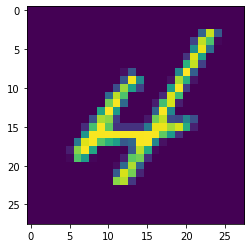

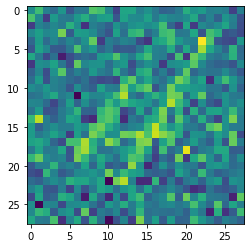

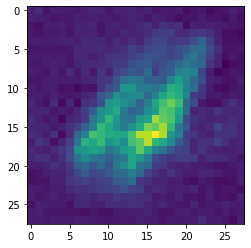

Epoch 1/50 [Train]:   0%|          | 1/1500 [00:00<08:00,  3.12it/s, Train Loss=0.0519]

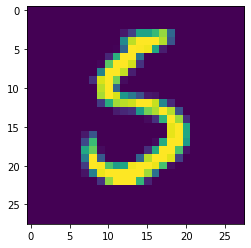

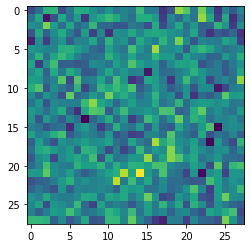

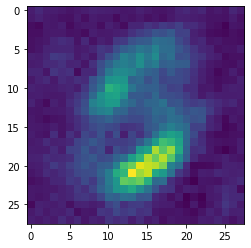

Epoch 1/50 [Train]:   0%|          | 2/1500 [00:00<06:34,  3.80it/s, Train Loss=0.0554]

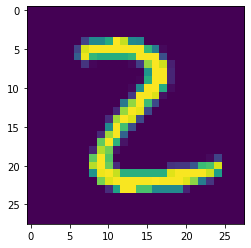

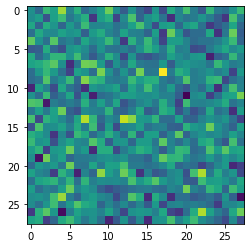

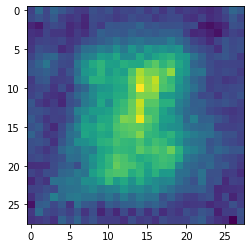

Epoch 1/50 [Train]:   0%|          | 3/1500 [00:00<06:01,  4.14it/s, Train Loss=0.0504]

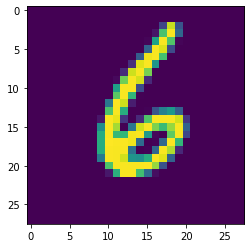

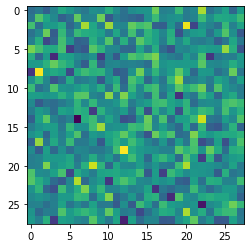

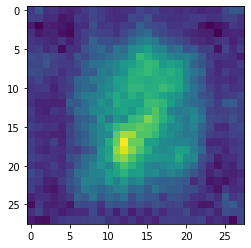

Epoch 1/50 [Train]:   0%|          | 4/1500 [00:00<05:44,  4.34it/s, Train Loss=0.0503]

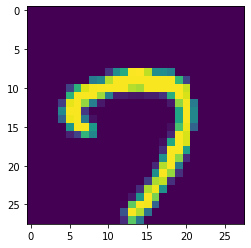

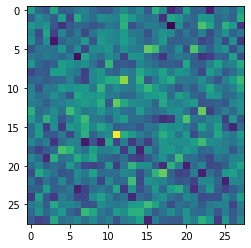

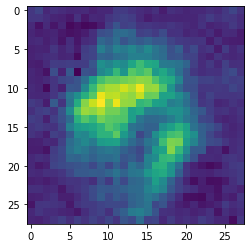

Epoch 1/50 [Train]:   0%|          | 5/1500 [00:01<05:35,  4.45it/s, Train Loss=0.0603]

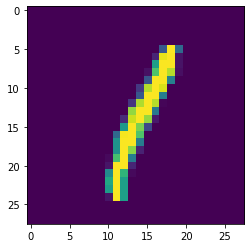

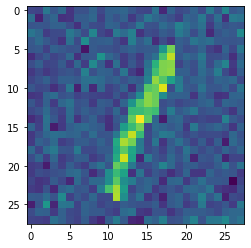

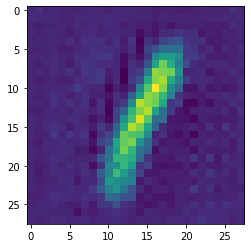

Epoch 1/50 [Train]:   0%|          | 6/1500 [00:01<06:19,  3.94it/s, Train Loss=0.0510]

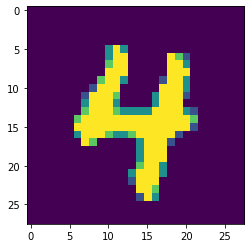

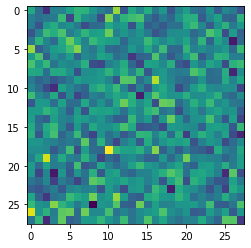

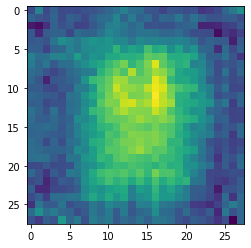

Epoch 1/50 [Train]:   0%|          | 7/1500 [00:01<06:35,  3.77it/s, Train Loss=0.0617]

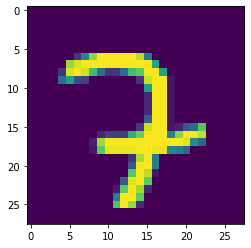

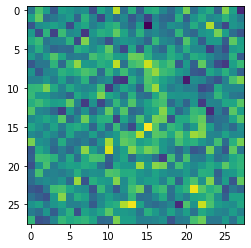

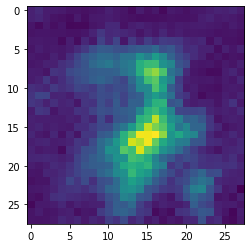

Epoch 1/50 [Train]:   1%|          | 8/1500 [00:02<06:12,  4.00it/s, Train Loss=0.0490]

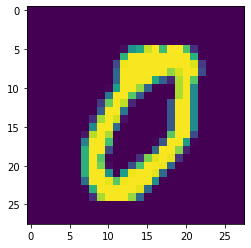

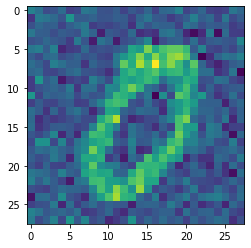

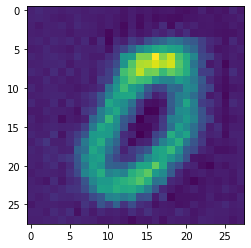

Epoch 1/50 [Train]:   1%|          | 9/1500 [00:02<06:33,  3.79it/s, Train Loss=0.0531]

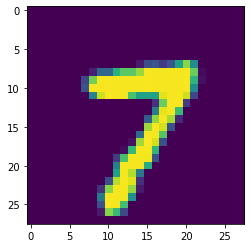

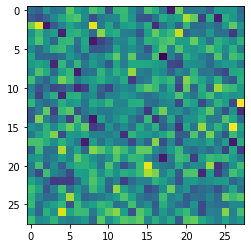

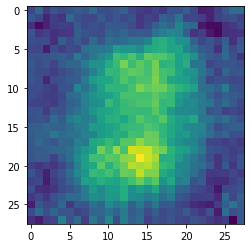

Epoch 1/50 [Train]:   1%|          | 10/1500 [00:02<06:26,  3.86it/s, Train Loss=0.0501]

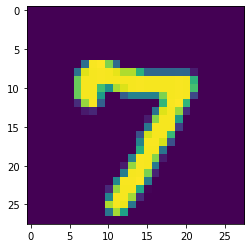

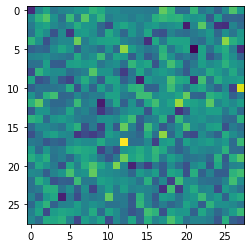

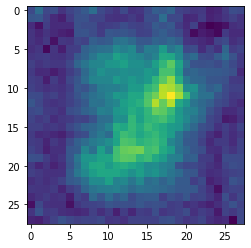

Epoch 1/50 [Train]:   1%|          | 11/1500 [00:02<06:15,  3.97it/s, Train Loss=0.0481]

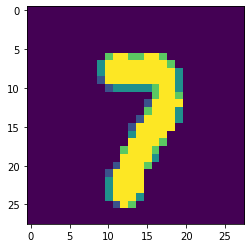

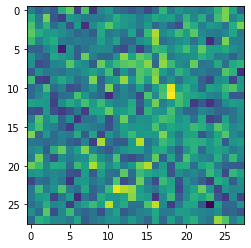

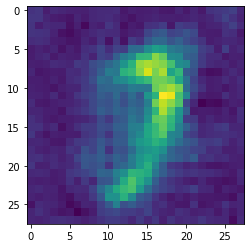

Epoch 1/50 [Train]:   1%|          | 12/1500 [00:03<06:38,  3.73it/s, Train Loss=0.0407]

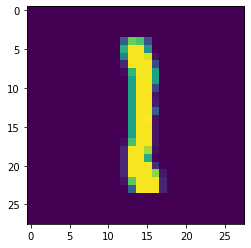

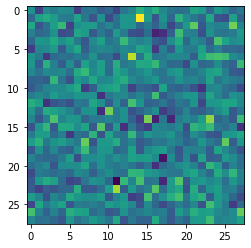

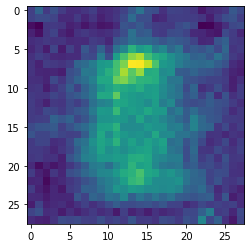

Epoch 1/50 [Train]:   1%|          | 13/1500 [00:03<06:18,  3.93it/s, Train Loss=0.0618]

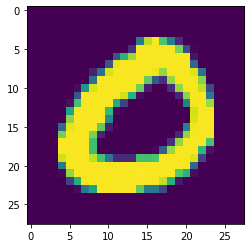

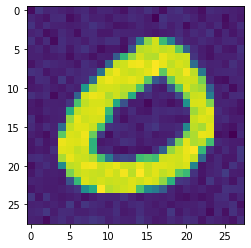

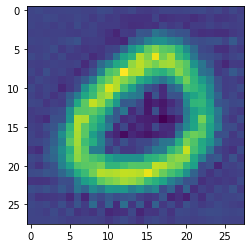

Epoch 1/50 [Train]:   1%|          | 14/1500 [00:03<06:02,  4.10it/s, Train Loss=0.0548]

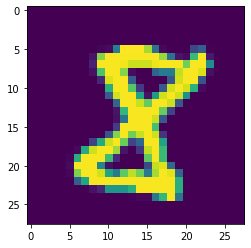

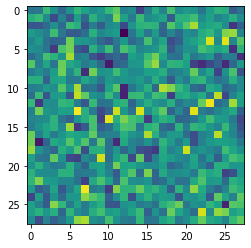

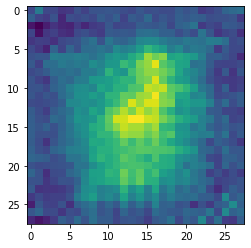

Epoch 1/50 [Train]:   1%|          | 15/1500 [00:03<05:53,  4.20it/s, Train Loss=0.0600]

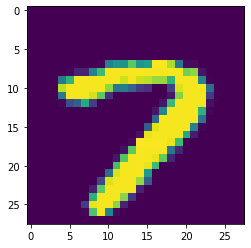

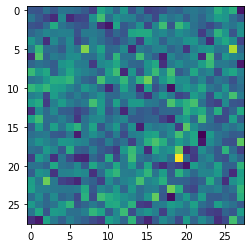

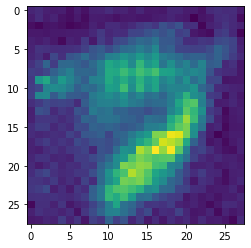

Epoch 1/50 [Train]:   1%|          | 16/1500 [00:04<06:21,  3.89it/s, Train Loss=0.0532]

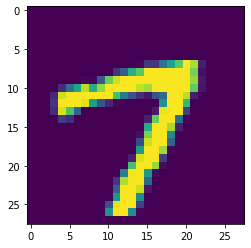

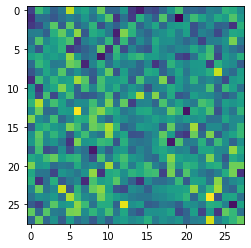

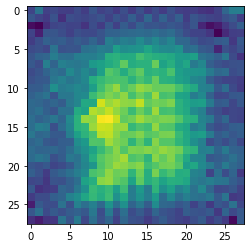

Epoch 1/50 [Train]:   1%|          | 17/1500 [00:04<06:06,  4.05it/s, Train Loss=0.0556]

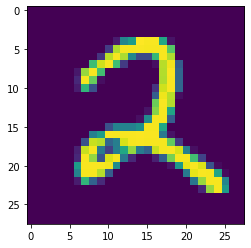

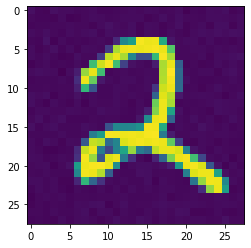

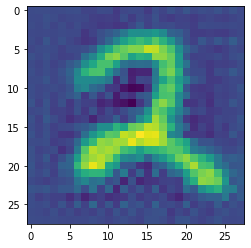

Epoch 1/50 [Train]:   1%|          | 18/1500 [00:04<05:55,  4.16it/s, Train Loss=0.0579]

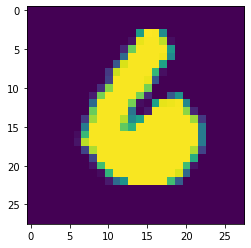

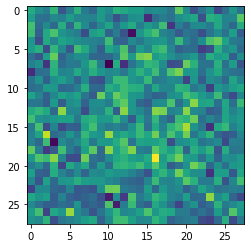

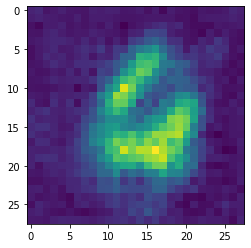

Epoch 1/50 [Train]:   1%|▏         | 19/1500 [00:04<05:46,  4.28it/s, Train Loss=0.0494]

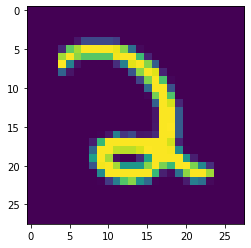

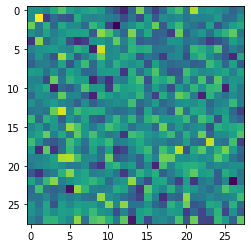

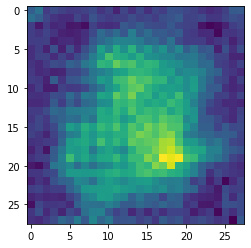

Epoch 1/50 [Train]:   1%|▏         | 20/1500 [00:05<09:14,  2.67it/s, Train Loss=0.0587]

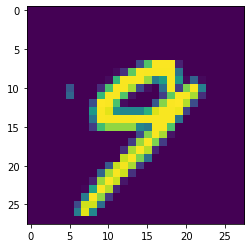

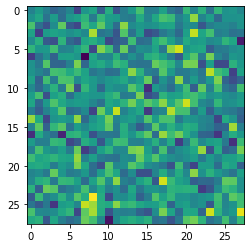

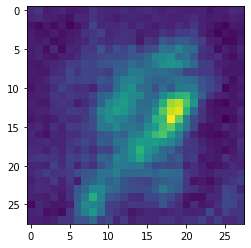

Epoch 1/50 [Train]:   1%|▏         | 21/1500 [00:05<08:11,  3.01it/s, Train Loss=0.0597]

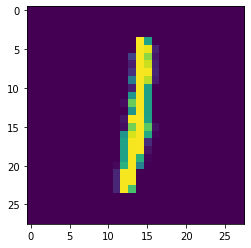

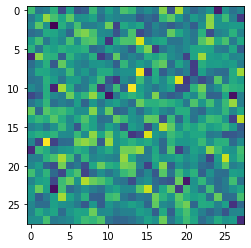

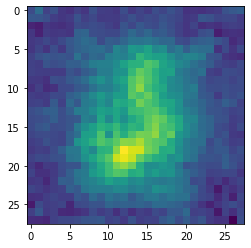

Epoch 1/50 [Train]:   1%|▏         | 22/1500 [00:05<07:22,  3.34it/s, Train Loss=0.0620]

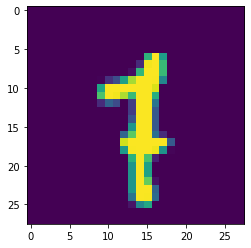

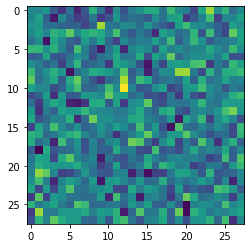

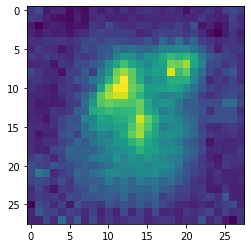

Epoch 1/50 [Train]:   2%|▏         | 23/1500 [00:06<07:06,  3.46it/s, Train Loss=0.0544]

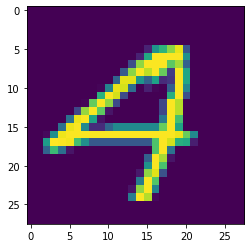

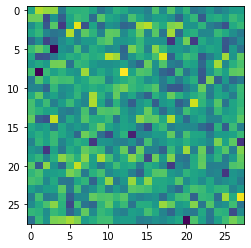

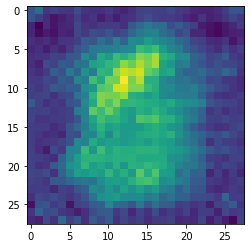

Epoch 1/50 [Train]:   2%|▏         | 24/1500 [00:06<06:59,  3.52it/s, Train Loss=0.0540]

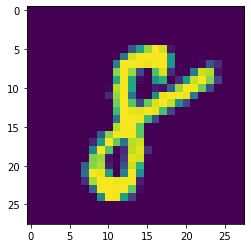

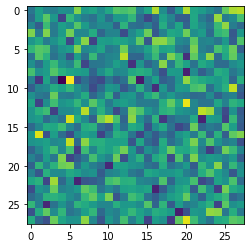

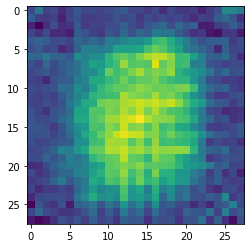

Epoch 1/50 [Train]:   2%|▏         | 25/1500 [00:06<06:31,  3.77it/s, Train Loss=0.0534]

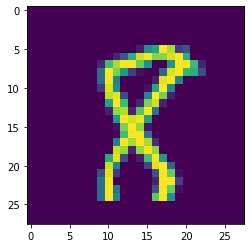

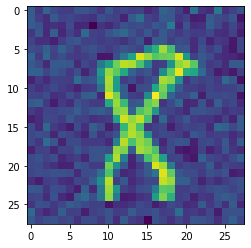

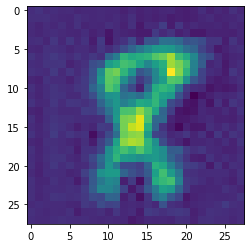

Epoch 1/50 [Train]:   2%|▏         | 26/1500 [00:06<06:09,  3.99it/s, Train Loss=0.0527]

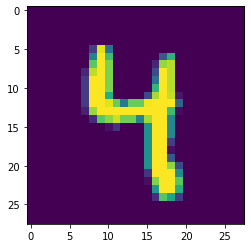

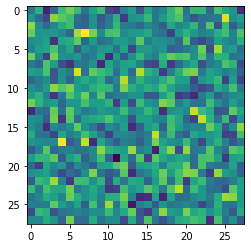

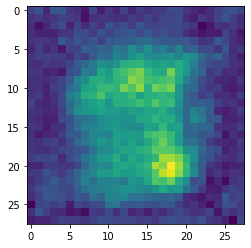

Epoch 1/50 [Train]:   2%|▏         | 27/1500 [00:07<05:54,  4.15it/s, Train Loss=0.0552]

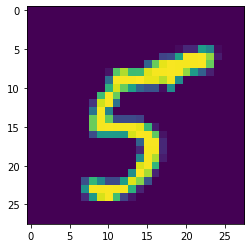

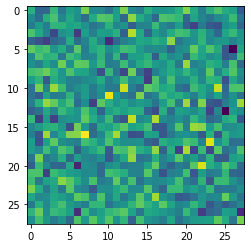

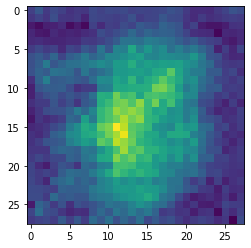

KeyboardInterrupt: 

In [40]:
from tqdm import tqdm

train_losses, val_losses = train(model= stableDiffusionModel,
                                 train_loader= trainloader,
                                 val_loader= valloader,
                                 optimizer= optimizer,
                                 criterion= criterion,
                                 device= device,
                                 num_epochs= num_epochs,
                                 diffuser= diffuser,
                                 totalTrainingTimesteps=total_timesteps)


torch.save(stableDiffusionModel.state_dict(), 'HW3SDModel.pth')

In [41]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

The Outputs for Random Seed {96}


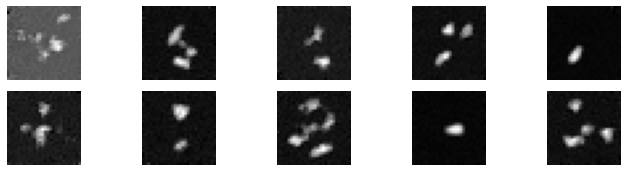

The Outputs for Random Seed {786}


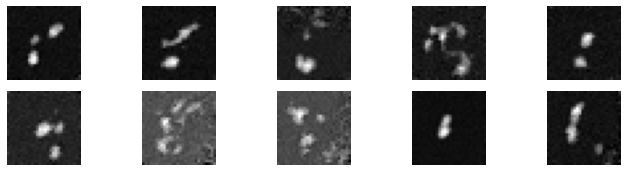

The Outputs for Random Seed {7150}


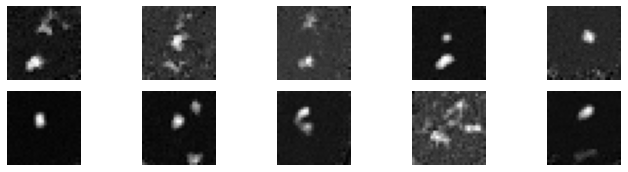

In [46]:
def generate_samples(x_t, model, num_samples, total_timesteps, diffuser, device):
    one_by_sqrt_alpha = 1 / torch.sqrt(diffuser.alphas)
    beta_by_sqrt_one_minus_alpha_cumprod = diffuser.betas / torch.sqrt(1 - diffuser.alpha_bar)

    for timestep in range(total_timesteps - 1, -1, -1):
        z = torch.randn_like(x_t)
        epsilon_t = model(x_t, torch.tensor([timestep], dtype=torch.float32).to(device).view(-1,1))
        x_t = one_by_sqrt_alpha[timestep] * (x_t - (beta_by_sqrt_one_minus_alpha_cumprod[timestep] * epsilon_t))
        
        if timestep > 0:
            x_t += torch.sqrt(diffuser.betas[timestep]) * z

    return x_t.detach()

diffuser = NoiseDiffuser(start_beta=startBeta, end_beta=endBeta, total_steps=total_timesteps, device= device)
# Using the function:
model_path = 'SDModel.pth'
model = UNet(in_channels=inputChannels, out_channels=outputChannels).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda")))
model.eval()



SEED = [96, 786, 7150]  # You can set any integer value for the seed

for S in SEED:
  print("The Outputs for Random Seed {%d}"%S)
  # Set seed for both CPU and CUDA devices
  torch.manual_seed(S)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(S)
      torch.cuda.manual_seed_all(S)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False

  num_samples_to_generate = 10
  # Initialize with random noise
  xt = torch.randn((num_samples_to_generate, 1, 28, 28), device=device)


  samples = generate_samples(xt, model, num_samples_to_generate, total_timesteps, diffuser, device)

  # Display the generated samples
  display_images(samples, num_samples_to_generate, images_per_row=5)
